# EDA : Exploratory Data Analysis 

In [1]:
# Nous avons besoins d'importer quelques modules 
import pandas as pd 
import numpy as np 
import geopandas as gpd 
import matplotlib.pyplot as plt 
import folium
import seaborn as sns
import requests 
import re
import os
from datetime import datetime
import plotly.express as px
import time

## Visualisons les bornes de recharge pour les véhicules électriques en France

Le jeu de données que nous allons utiliser date du 23 juillet 2023, vous pouvez le retrouver sur cette [page](https://www.data.gouv.fr/fr/datasets/bornes-de-recharge-pour-vehicules-electriques-3/).

In [2]:
# On commence par récupérer notre data set 
URL = 'https://www.data.gouv.fr/fr/datasets/r/517258d5-aee7-4fa4-ac02-bd83ede23d25'
df = pd.read_csv(URL, sep = ';')

In [3]:
df.sample(5)

,n_amenageur,n_operateur,n_enseigne,id_station,n_station,ad_station,code_insee,xlongitude,ylatitude,nbre_pdc,...,type_prise,acces_recharge,accessibilite,observations,date_maj,source,geo_point_borne,code_insee_commune,region,departement
2616,SYANE,SYANE,E Born,FR*S74*P74121*A,EXCENEVEX_Avenue de la Plage,Avenue de la Plage 74140 EXCENEVEX,74121.0,6.358175,46.346000,NaN,...,E/F + T2,Payant,24/24 7/7 jours,NaN,2020-03-24,https://www.data.gouv.fr/fr/datasets/syane-bor...,"46.3459998,6.3581754",74121,Auvergne-Rhône-Alpes,Haute-Savoie
10506,Ville d'Hazebrouck,BOUYGUES ENERGIES ET SERVICES,pass pass électrique,FR*H08*P59295*001,HAZEBROUCK - Rue de la plaine,Rue de la plaine 59190 HAZEBROUCK,59295.0,2.552611,50.730270,2.0,...,EF - T2,payant,24h/24 7j/7,Recharge par badge et avec une application sma...,2020-04-03,https://www.data.gouv.fr/fr/datasets/infrastru...,"50.73027,2.552611",59295,Hauts-de-France,Nord
4420,Mairie de Paris,Mairie de Paris,Paris Recharge,FR*W75*PVP*0089,110 BOULEVARD RICHARD LENOIR,"110 BOULEVARD RICHARD LENOIR, 75011 PARIS",75111.0,2.371399,48.864062,6.0,...,prise T3,payant,7/7-24/24,Courant: AC mono|tarif: 120€/an|https://www.pa...,2020-07-22,https://www.data.gouv.fr/fr/datasets/paris-rec...,"48.8640621,2.3713985",75056,Île-de-France,Paris
9756,TOTAL MARKETING FRANCE,TOTAL MARKETING FRANCE,Belib',FR*V75*PPX11*08,Paris | Boulevard Richard Lenoir 36,"36 Boulevard Richard Lenoir, 75011 Paris",75111.0,2.371390,48.857258,4.0,...,T2-EF,payant,7/7-24/24,https://belib.paris,2021-06-02,https://www.data.gouv.fr/fr/datasets/belib-poi...,"48.857258,2.37139",75056,Île-de-France,Paris
1702,SDE76,Sodetrel,SDE76,FR*SOD*P*SDE7*79*_*_*_,Trouville-Alliquerville,Route de l'Eglise,76715.0,0.527887,49.584935,2.0,...,E/F-T2,payant,24/24 7/7,RFID et application,2018-04-11,https://www.data.gouv.fr/fr/datasets/bornes-de...,"49.584935,0.527887",76382,Normandie,Seine-Maritime


### Catégories d'accès à la borne : 

Comme l'illustre la cellule de code suivante, les catégories proposées ne sont pas très propres. Remédions à cela.

In [4]:
list(df['acces_recharge'].unique())

[nan,
 'Gratuit',
 'Payant',
 'payant',
 'gratuit',
 'oui',
 '5€ / 45min, si abonné (10€/mois) : 1€/10min',
 'Réservation préalable, accès par badge',
 '0.19€/kWh + 0.01€/min',
 'Public payant',
 'QR code / appli mobile / Carte RFID',
 'gratuit pour la clientèle du parking',
 'badge RFID; QR Code',
 'Charges gratuites de 12 à 14h et de 19h à 21h',
 'Payant (badge, appli et QR code)',
 'GRATUIT',
 '2€/recharge',
 'Carte Mobive',
 'Accès payant (Badge RFID, application, site web paynow.sodetrel.fr, badges vendus en boutique)',
 '2€/recharge+ prix du stationnement']

In [5]:
def transform_acces(row):
    if not pd.isna(row):  # On ne peut rien dire des nan
        row = row.lower()  # Mettre en lettre minuscule 
        mots = row.split(' ')
        if 'payant' in mots: row = 'payant'
        elif 'gratuit' in mots: row = 'gratuit'
        for mot in mots: 
            if len(mot.split('€'))>1: row = 'payant'
            if mot=='carte' or mot=='badge': row = 'carte ou badge'
            if mot=='oui': row = 'information manquante'
        #else: row = 'accès spécial'
    else: row = 'information manquante'
    return row
df['acces_recharge'] = df['acces_recharge'].apply(transform_acces)
list(df['acces_recharge'].unique())

['information manquante',
 'gratuit',
 'payant',
 'carte ou badge',
 'charges gratuites de 12 à 14h et de 19h à 21h']

### On veut ensuite s'assurer que nous disposons de toutes les informations concernant les coordonénes géographiques des bornes de recharge ... 

Il y a  30 valeurs manquantes pour xlongitude
Il y a  6 valeurs manquantes pour ylatitude


<Axes: >

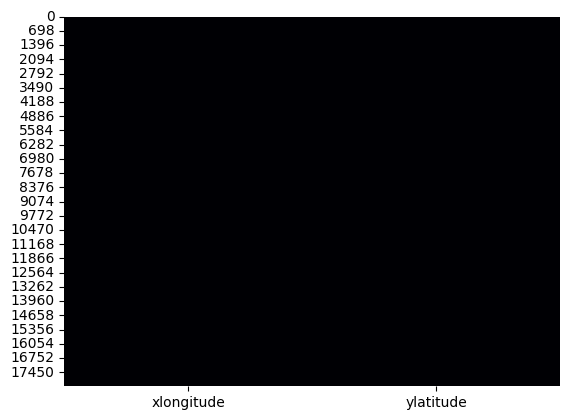

In [6]:
print('Il y a ', df[df['xlongitude'].isna()].shape[0], 'valeurs manquantes pour xlongitude')
print('Il y a ', df[df['ylatitude'].isna()].shape[0], 'valeurs manquantes pour ylatitude')
sns.heatmap(df[['xlongitude', 'ylatitude']].isna(), cmap = 'magma', cbar = False)

In [7]:
droping_liste = list(set(df[df['xlongitude'].isna()].index.to_list() + df[df['ylatitude'].isna()].index.to_list()))
df.drop(droping_liste, inplace = True)

### Regardons plus attentivement la répartition des bornes en France

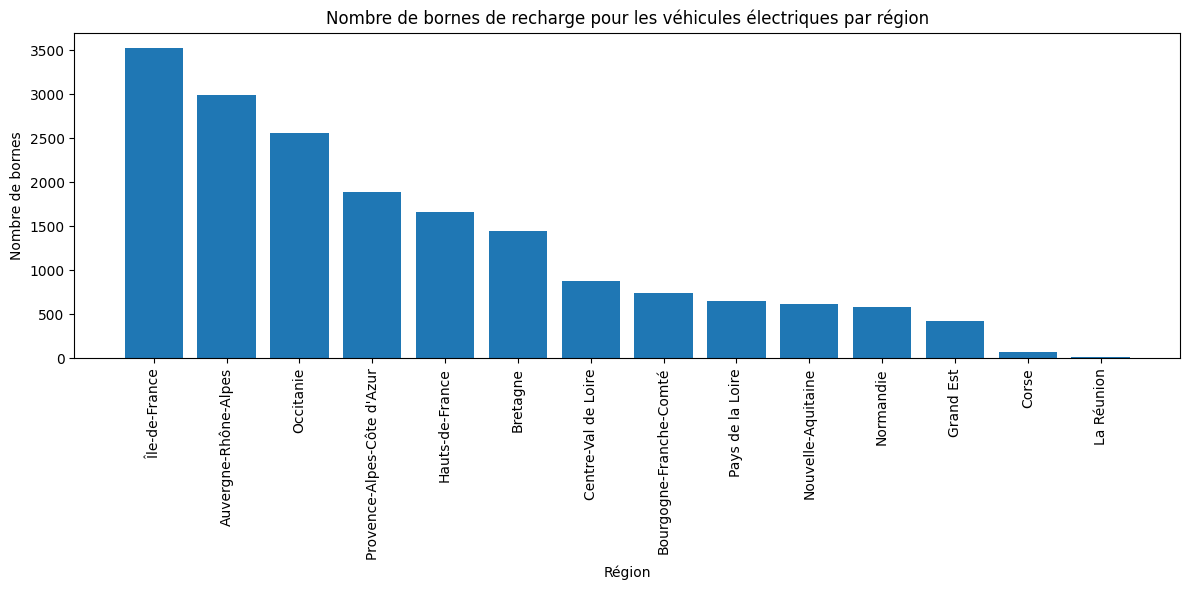

In [8]:
bornes_region = df['region'].value_counts().reset_index()  # On compte le nombre de bornes par région
bornes_region.columns = ['region', 'nombre de bornes']
bornes_region = bornes_region.sort_values(by='nombre de bornes', ascending=False)

# On affiche cela dans un histogramme 
plt.figure(figsize=(12, 6))
plt.bar(bornes_region['region'], bornes_region['nombre de bornes'])
plt.xlabel('Région')
plt.ylabel('Nombre de bornes')
plt.title('Nombre de bornes de recharge pour les véhicules électriques par région')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
# Quelques modifications pour le futur merge
bornes_region['region'][11] = 'Grand Est'
bornes_region['region'][9] = 'Île-de-France'
bornes_region['region'][8] = 'Centre-Val-de-Loire'

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1870/1969680242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bornes_region['region'][11] = 'Grand Est'
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1870/1969680242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bornes_region['region'][9] = 'Île-de-France'
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_1870/1969680242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

#### un peu de curiosité : on peut se demander si le nombre de bornes est proportionnel au nombre d'habitants par régions. 

In [10]:
pop_region = pd.read_excel('/Users/augustincablant/Documents/GitHub/Projet_python_2A/download/estim-pop-nreg-sexe-gca-1975-2023.xls', 
                           sheet_name = '2023')
# On ne veut récupérer que le nom des régions et la population totale dans ces régions 
pop_region = pop_region.iloc[4:17, [0,7]]
pop_region.columns = ['region', "nb d'habitants"]
pop_region.sort_values(by = "nb d'habitants", inplace = True)
pop_region.head(10)

,region,nb d'habitants
8,Corse,35976
7,Centre-Val-de-Loire,304612
5,Bourgogne-Franche-Comté,316292
12,Normandie,395819
6,Bretagne,396786
15,Pays de la Loire,480155
16,Provence-Alpes-Côte d'Azur,581553
9,Grand Est,641637
13,Nouvelle-Aquitaine,661165
14,Occitanie,685964


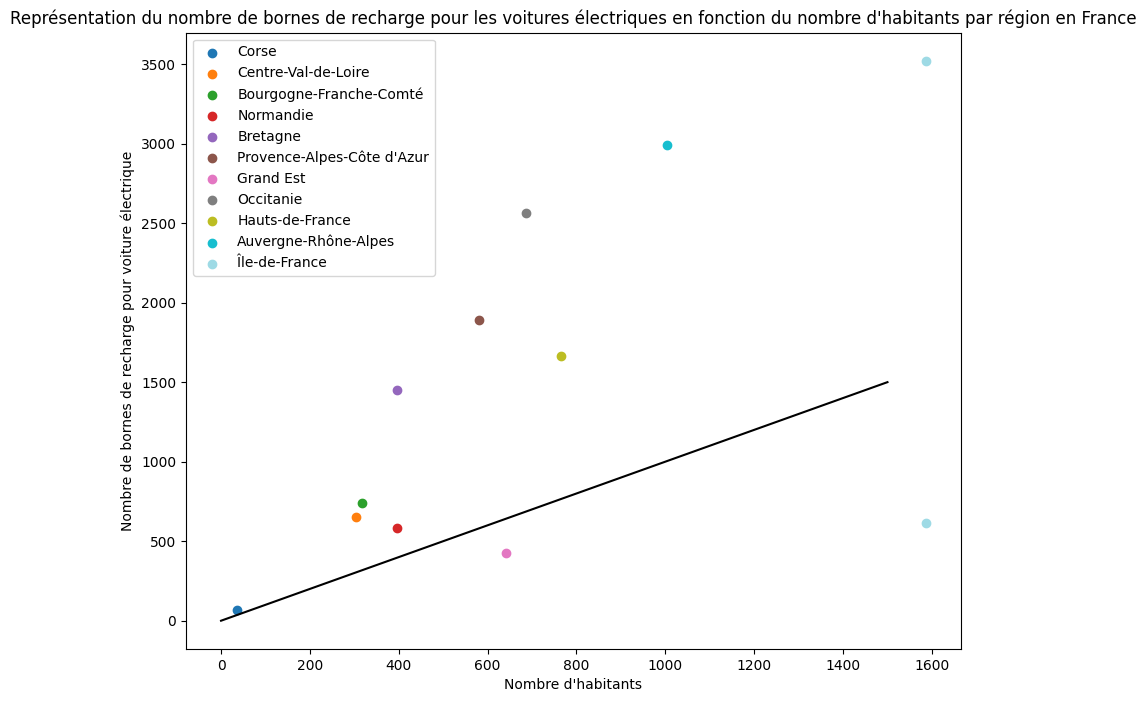

In [11]:
merge_region = pd.merge(pop_region, bornes_region, on = 'region')

# On met à la même échelle pour effectuer une représentation par un nuage de point 
regions = merge_region['region'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(regions)))
merge_region['nb d\'habitants'] = merge_region['nb d\'habitants'] * 10**(-3)
# Représentation
plt.figure(figsize=(10,8))
for i, region in enumerate(regions):
    subset = merge_region[merge_region['region'] == region]
    plt.scatter(subset["nb d'habitants"], subset['nombre de bornes'], label=region, color=colors[i])
x = np.linspace(0, 1500, 1000)
plt.plot(x, x, color='black')
plt.xlabel('Nombre d\'habitants')
plt.ylabel('Nombre de bornes de recharge pour voiture électrique')
plt.title("Représentation du nombre de bornes de recharge pour les voitures électriques en fonction du nombre d\'habitants par région en France")
plt.legend()
plt.show()

### Encore mieux, on peut se demander si le nombre de bornes est proportionnel au nombre de voitures électriques présentes dans ces régions. 

i) Commençons par regarder l'évolution du nombre de véhicules électrique en France depuis 2010 

ii) Puis regardons la répartition des nouveaux véhicules électriques en France en 2018

In [12]:
# Commençons par regarder l'évolution du nombre de véhicules électrique
# Pour cela nous avons scrappé les données de wikipedia, le contenu se trouve dans le dossier SCRAP : 'scrap_VE.py'
EVOL_VE = pd.read_csv('SCRAP/EVOL_VE.csv')
fig, ax1 = plt.subplots()
ax1.plot(EVOL_VE['Année'], EVOL_VE['Part de marché'], color='red', alpha=0.8, label='Part de marché des véhicules électrique')
ax1.set_xlabel('Années')
ax1.set_ylabel('Parts de marché')
ax1.set_xlim(2010, 2023)
ax2 = ax1.twinx()
ax2.scatter(EVOL_VE['Année'], EVOL_VE['Voitures particulières'], color='blue', label='Voitures particulières')
ax2.scatter(EVOL_VE['Année'], EVOL_VE['Utilitaires'], color='orange', label='Utilitaires')
ax2.set_ylabel('Nombre de voitures')
ax1.legend()
ax2.legend(loc = 'center left')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'SCRAP/EVOL_VE.csv'